In [1]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
import joblib
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

In [2]:
# we are looking here to find optimal parameters for ML: (random split train/test + dimensionality reduction with PCA)

In [3]:
# Load dataset from npz files
dict_X = np.load('../dataset/X.npz')
dict_y = np.load('../dataset/y.npz')
# Store arrays from dictionary
X = dict_X['arr_0']
y = dict_y['arr_0']

In [4]:
# we will look first at training a model using PCA first and SVM with rbf
# data split training/test sets for cross-validations
cv_splits = StratifiedShuffleSplit(n_splits=5, test_size=0.25, random_state=42)

In [5]:
# I would need a pipeline of PCA and SVM to do my parameter optimization/cross-validation

# initialize PCA with n_components
n_PCA = 10
pca = PCA(n_components=n_PCA, whiten=True, svd_solver='randomized', random_state=42)
# initialize SVM with Radial Basis Functions (rbf) and balanced weights (although dataset is pretty balanced)
# possible parameter to explore in the future: break_ties (at increased comp. cost)
sv_clf = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(pca, sv_clf)

In [6]:
# Now I'm looking into parameter tuning for X_train_PCA,y_train using SVM classifier with RBF
# C_range = np.logspace(3, 6, 4)
C_range = np.linspace(1e4, 1e5, 4)
# gamma_range = np.logspace(-6, -3, 4)
gamma_range = np.linspace(1e-3, 1e-2, 4)
sv_grid = dict(svc__gamma = gamma_range, svc__C = C_range)

In [7]:
# cross-validation parameter optimization with PCA transformation into SVM classifier
pca_sv_clf = GridSearchCV(model, param_grid = sv_grid, cv = cv_splits)


In [8]:
# fit different X train splits and time
%time pca_sv_clf.fit(X, y)


Wall time: 5min 50s


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=42, test_size=0.25,
            train_size=None),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('pca',
                                        PCA(copy=True, iterated_power='auto',
                                            n_components=10, random_state=42,
                                            svd_solver='randomized', tol=0.0,
                                            whiten=True)),
                                       ('svc',
                                        SVC(C=1.0, break_ties=False,
                                            cache_size=200,
                                            class_weight='balanced', coef...
                                            degree=3, gamma='scale',
                                            kernel='rbf', max_iter=-1,
                                            probability=False,
               

In [9]:
# parameter testing results
# pca_sv_clf.best_params_

In [15]:
pca_sv_clf.cv_results_

{'mean_fit_time': array([4.1070673 , 5.84176173, 4.09272542, 3.66226053, 4.19842319,
        3.86458597, 3.75949984, 3.79015164, 4.82449627, 4.12831731,
        3.47165279, 3.46005092, 4.50092573, 3.66202192, 3.61862049,
        3.50747685]),
 'std_fit_time': array([0.26173095, 0.93316367, 0.34558179, 0.28471789, 0.09751982,
        0.19452717, 0.23369898, 0.10107247, 0.32065876, 0.50726132,
        0.08479943, 0.07609233, 0.31796278, 0.12564421, 0.08671509,
        0.09416029]),
 'mean_score_time': array([0.27789774, 0.32661033, 0.27059212, 0.2684104 , 0.24674888,
        0.26948719, 0.24594955, 0.28545208, 0.30685768, 0.30417714,
        0.25110888, 0.24266291, 0.25380397, 0.25468388, 0.25861039,
        0.2540309 ]),
 'std_score_time': array([0.05805876, 0.06099765, 0.02032089, 0.03427231, 0.01097146,
        0.03854519, 0.01346272, 0.0423074 , 0.06701742, 0.06489674,
        0.01462691, 0.00817485, 0.01788274, 0.03076405, 0.02959507,
        0.02634493]),
 'param_svc__C': masked_ar

In [11]:
# idxRank = pca_sv_clf.cv_results_['rank_test_score']
# for index, item in enumerate(pca_sv_clf.cv_results_['params']):
#     print(f"{item} - {idxRank[index]}")

In [12]:
# save the model to disk
# filename = f"../dataset/grid_{n_PCA}_16.sav"
# joblib.dump(pca_sv_clf, filename)

In [16]:
scores = pca_sv_clf.cv_results_['mean_test_score'].reshape(len(C_range),
                                                     len(gamma_range))

In [17]:
# Utility function to move the midpoint of a colormap to be around
# the values of interest.

class MidpointNormalize(Normalize):

    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

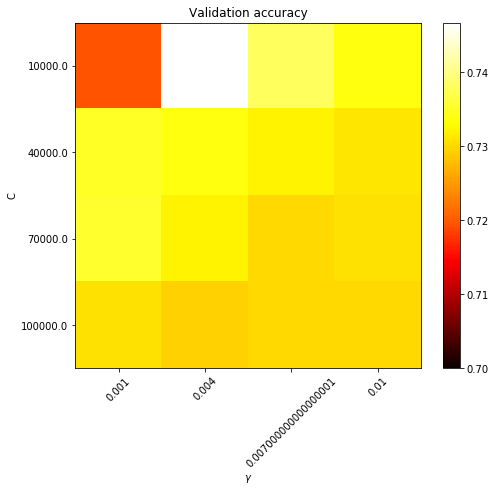

In [21]:
plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot,
           norm=MidpointNormalize(vmin=0.7, midpoint=0.72))
plt.xlabel('$\gamma$')
plt.ylabel('C')
plt.colorbar()
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
plt.yticks(np.arange(len(C_range)), C_range)
plt.title('Validation accuracy')
plt.show()

In [ ]:
# load trained model from disk
# filename = f"../dataset/grid_{n_PCA}_16.sav"
# loaded_model = joblib.load(filename)

In [ ]:
# loaded_model.cv_results_